## Deep Convolutional Classificator using Fashion MNIST dataset

![alt text](fashion-mnist_long.png)

In this project, we will make a convolutional neural network (hereafter CNN) to classify the different fashion images contained on the [Fashion MNIST dataset](https://www.kaggle.com/zalando-research/fashionmnist). This dataset consists of a set of 70000 images of 28 x 28 pixels in greyscale. Such images can be of 10 different labels, corresponding to 

| Label number | Label |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

We will implement a CNN whose aim is to predict the label given the image. Let us start importing the packages.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import matplotlib.font_manager
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
#from torchviz import make_dot
import torch.optim as optim

As usual in machine learning models, we need to define the hyperparameters of the CNN. We do this now because it is very important to be organized while programming and we will need the batch size soon, so we put all these parameters together and we present them now.

In [2]:
# Model parameters
n_inputs = 196
n_hidden = 98
n_outputs = 10
in_channels = 1
out_channels = 1
kernel_size_1 = 7
kernel_size_2 = 5
p_dropout = 0.1   # Dropout probability
batch_size = 1000   # Mini-batch
lr = 1e-3   # Learning rate
n_epochs = 200   # Number of epochs

# Fonts to the plots
fuente_ejes = matplotlib.font_manager.FontProperties()
fuente_ejes.set_family('serif')
fuente_ejes.set_style('normal')
    
fuente_nombre = matplotlib.font_manager.FontProperties()
fuente_nombre.set_family('serif')
fuente_nombre.set_style('italic')

fuente_titulo = matplotlib.font_manager.FontProperties()
fuente_titulo.set_size(10)
fuente_titulo.set_name('cursive')
fuente_titulo.set_style('normal')
fuente_titulo.set_weight('semibold')

In [3]:
# We create a custom Dataset class to work the images
class CustomImageDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
        
    # We redefine the __len__() method
    def __len__(self):
        return len(self.dataset)
    
    # Redefinimos el método .__getitem__()
    def __getitem__(self, i):
        image, label = self.dataset[i]
        # We rewrite the original label to allow it be able to be compared against the model predictions
        zer = torch.zeros(10)
        zer[label] = 1.
        label = zer
        return image, label

In [4]:
# Download training data
train_d = FashionMNIST(
    root='Dataset',
    train=True,
    download=True,
    transform=ToTensor(),
)

train_data = train_d
train_data = CustomImageDataset(train_data)

# Download test data
test_d = FashionMNIST(
    root="Dataset",
    train=False,
    download=True,
    transform=ToTensor(),
)

test_data = test_d
test_data = CustomImageDataset(test_data)

In [5]:
# Check some info about the data downloaded
train_data.__class__.__mro__

(__main__.CustomImageDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [6]:
# Check some info about the data downloaded
test_data.__class__.__mro__

(__main__.CustomImageDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

Once we have loaded the Dataset objects it is time to instantiate the Dataloader objects in order to get the proper inputs to the CNN. Also, it is possible to train the CNN in batches if the inputs are Dataloader objects.

In [5]:
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False)

We can check if cuda is available for training. The use of cuda optimizes the training process, allowing us to use the different GPUs we have in our computer.

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Now we have loaded the dataset and we transformed it in appropiate Dataloader objects, it is time to define the model we will train to predict the label of the image used as input. As said before, the model is a CNN, and the architecture of such a network will be explained right now.

In [7]:
# Model definition
class Model(nn.Module):
    # Define model elements
    def __init__(self, ):
        # The super() builtin returns a proxy object (temporary object of the superclass)
        # that allows us to access methods of the base class.
        super().__init__()
        # Sequence of transformations implemented by the layers of the network
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size_1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size_2, stride=1),
            nn.Conv2d(in_channels, out_channels, kernel_size_2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(n_inputs, n_hidden),
            nn.Dropout(0.1),
            nn.ReLU(),
            nn.Linear(n_hidden, n_outputs),
            nn.Softmax()
        )
 
    # Method to transform inputs in outputs considering the internal structure of the network
    def forward(self, X):
        output = self.cnn(X)
        return output
    
# Now we can create a model and send it at once to the device
model = Model().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())
print(model)

OrderedDict([('cnn.0.weight', tensor([[[[-0.0436, -0.0458, -0.0993,  0.1115,  0.1045, -0.0178,  0.0092],
          [-0.1251,  0.0607,  0.0067,  0.0295,  0.1311, -0.0395,  0.1348],
          [ 0.0230,  0.0409, -0.0797, -0.1183, -0.0738,  0.1226, -0.0258],
          [ 0.0197, -0.0434,  0.0105,  0.0321,  0.0939, -0.1249, -0.1358],
          [-0.1031,  0.0396,  0.1084,  0.0708, -0.0874, -0.1241,  0.0060],
          [ 0.0284,  0.0161,  0.0021,  0.0781, -0.0369,  0.0888,  0.0633],
          [ 0.1062, -0.1329,  0.1321,  0.0803,  0.0488,  0.0124, -0.0149]]]])), ('cnn.0.bias', tensor([-0.1154])), ('cnn.3.weight', tensor([[[[-0.1669,  0.1089, -0.0320, -0.0517,  0.0664],
          [ 0.1982, -0.1037, -0.1959,  0.1293, -0.1909],
          [ 0.1060, -0.1768, -0.1372,  0.0995, -0.1490],
          [-0.0032, -0.0834,  0.1559,  0.0365, -0.0448],
          [-0.0697, -0.0719, -0.1015, -0.1751, -0.1110]]]])), ('cnn.3.bias', tensor([-0.1679])), ('cnn.6.weight', tensor([[ 0.0583, -0.0695,  0.0342,  ...,  0.0

Now we have defined the model we want to train, let us take a look at the dataset.

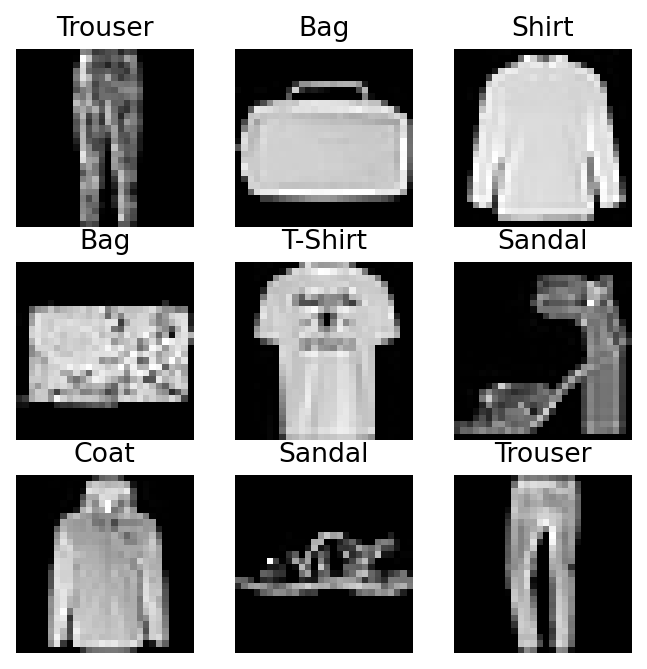

In [8]:
# Labels of the clothes
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Plot of a random sample of tain_data
figure = plt.figure(figsize=(5, 5), dpi=160)
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(train_d), size=(1,)).item()
    img, label = train_d[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
#plt.savefig('examples.jpg', bbox_inches='tight')

Let us make some statistical analysis regarding the labels. In doing so, we are going to be able to see if the dataset is imbalanced or not.

In [11]:
# Let us convert the targets tensor into a pandas DataFrame object to make easier the computations
df = pd.DataFrame(train_d.targets.numpy(), columns = ['Labels'])

Now we have a DataFRame object we can inspect the targets.

In [12]:
# Let us se the value counts of the labels
df.value_counts()

Labels
0         6000
1         6000
2         6000
3         6000
4         6000
5         6000
6         6000
7         6000
8         6000
9         6000
dtype: int64

We can see that the training labels are perfectly balanced, making the training process easier than in the case of imbalanced classes. Note that we have labels that are encoded, so it is not needed to apply the label encoding method on the targets. To move forward, we have to define the function that will perform the training of the CNN.

In [10]:
for (X, y) in train_dl:
    print(X.shape)
    break
    
len(train_dl.dataset)/1000

torch.Size([1, 28, 28])


60.0

In [17]:
# We define the training function
def train_loop(dataloader, model, loss_fn, optimizer):
    size = int(len(dataloader.dataset)/1000)
    tmp = []

    # We iterate over batches
    for batch, (X, y) in enumerate(dataloader):
        # We calculate the model's prediction
        pred = model(X)
        # With the model prediction we calculate the loss function
        loss = loss_fn(pred, y)

        # We apply the backpropagation method
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Training progress
        loss, current = loss.item(), batch
        tmp.append(loss)
        print(f"Actual batch={current} | Loss={loss:>7f} | Processed samples:[{current:>5d}/{size:>5d}]")
    
    tmp = np.array(tmp)
    loss_avg = tmp.sum()/len(tmp)
    return loss_avg

# We define the test function
def test_loop(dataloader, model, loss_fn, num_batches):
    size = int(len(dataloader.dataset)/1000)
    test_loss = 0
    j = 0
    
    # To test, we need to deactivate the calculation of the gradients
    with torch.no_grad():
        # We iterate over batches
        for X, y in dataloader:
            # Model's prection
            pred = model(X)
            # Corresponding errors, which we acumulate in a total value
            test_loss += loss_fn(pred, y).item()
            j += 1
            
    # We calculate the total loss and print it
    test_loss /= j
    print(f"Test Error: Avg loss = {test_loss:>8f} \n")
    return test_loss

In order to train the model, we need to instanciate an optimizer object and a loss function object. Let us do this.

In [14]:
# Loss function object. It is a Medium Squared Error.
loss_fn = nn.MSELoss()

# We instantiate an optimizer. In this case we choose Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-08, weight_decay=0, amsgrad=False)

In [15]:
# Print model's state_dict size to gain some perspective about the model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
cnn.0.weight 	 torch.Size([1, 1, 7, 7])
cnn.0.bias 	 torch.Size([1])
cnn.3.weight 	 torch.Size([1, 1, 5, 5])
cnn.3.bias 	 torch.Size([1])
cnn.6.weight 	 torch.Size([98, 196])
cnn.6.bias 	 torch.Size([98])
cnn.9.weight 	 torch.Size([10, 98])
cnn.9.bias 	 torch.Size([10])


We will plot the loss function against the epochs

In [16]:
# We define a loss array to plot the training loss function and the testing loss function
loss_to_plot = []
loss_to_plot_val = []

We are ready to train the model. Let us train it during $n_{epochs}$ epochs, as defined above.

In [18]:
# We train the model iterating over the different epochs
for t in range(n_epochs):
    print(f"Epoch {t+1}\n=============================================")
    loss_to_plot.append(train_loop(train_dl, model, loss_fn, optimizer))
    loss_to_plot_val.append(test_loop(test_dl, model, loss_fn, batch_size))
print("Done!")

Epoch 1


C:\Users\santy\anaconda3\envs\env-ml\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Actual batch=0 | loss=0.090194 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.090008 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.090043 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.090059 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.090027 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.089963 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.089931 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.089942 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.089786 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.089834 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.089719 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.089718 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.089641 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.089486 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.089476 | muestras procesadas:[   

Test Error: Avg loss = 0.043632 

Epoch 3
Actual batch=0 | loss=0.042466 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.040737 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.042365 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.043429 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.040376 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.042881 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.041445 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.044549 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.045278 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.040803 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.044814 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.040387 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.039925 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.042754 | muestras procesadas:[   13/   60]
Actual batch=14 

Actual batch=59 | loss=0.035743 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.036748 

Epoch 5
Actual batch=0 | loss=0.036625 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.034539 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.036548 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.035461 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.035262 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.037694 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.033702 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.036289 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.036511 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.036967 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.034378 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.036288 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.034319 | muestras procesadas:[   12/   60]
Actual batch=13 

Actual batch=58 | loss=0.032411 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.032556 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.034317 

Epoch 7
Actual batch=0 | loss=0.032255 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.032393 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.034172 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.034250 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.030786 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.032646 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.031660 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.036006 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.032937 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.033313 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.029354 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.031944 | muestras procesadas:[   11/   60]
Actual batch=12 

Actual batch=57 | loss=0.032644 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.031645 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.029506 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.031667 

Epoch 9
Actual batch=0 | loss=0.029835 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.029522 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.027662 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.028839 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.031576 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.031049 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.030808 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.032497 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.030492 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.030704 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.028674 | muestras procesadas:[   10/   60]
Actual batch=11 

Actual batch=57 | loss=0.029302 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.030823 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.030218 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.030548 

Epoch 11
Actual batch=0 | loss=0.028645 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.028583 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.030508 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.029618 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.029638 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.030776 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.030680 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.030456 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.029194 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.029371 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.028439 | muestras procesadas:[   10/   60]
Actual batch=11

Actual batch=56 | loss=0.030571 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.027386 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.027999 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.028645 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.029465 

Epoch 13
Actual batch=0 | loss=0.028799 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.027600 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.029576 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.029822 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.028390 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.028254 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.026237 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.028303 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.028907 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.026360 | muestras procesadas:[    9/   60]
Actual batch=10

Actual batch=55 | loss=0.026425 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.027370 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.028166 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.029130 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.027170 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.028954 

Epoch 15
Actual batch=0 | loss=0.028750 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.026826 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.026956 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.030063 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.027954 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.027209 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.025980 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.024453 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.028932 | muestras procesadas:[    8/   60]
Actual batch=9

Actual batch=54 | loss=0.027919 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.028984 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.026766 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.024676 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.027884 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.029490 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.027788 

Epoch 17
Actual batch=0 | loss=0.027071 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.024580 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.026656 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.026551 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.027748 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.027878 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.028557 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.026410 | muestras procesadas:[    7/   60]
Actual batch=

Actual batch=54 | loss=0.029341 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.025061 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.027042 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.024796 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.023459 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.026510 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.027864 

Epoch 19
Actual batch=0 | loss=0.027901 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.028335 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.028420 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.026323 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.025439 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.029368 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.025764 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.025387 | muestras procesadas:[    7/   60]
Actual batch=

Actual batch=54 | loss=0.023275 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.027922 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.024186 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.026550 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.026156 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.027384 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.027612 

Epoch 21
Actual batch=0 | loss=0.025417 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.028433 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.026835 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.026433 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.026068 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.027065 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.027645 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.027496 | muestras procesadas:[    7/   60]
Actual batch=

Actual batch=53 | loss=0.023959 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.023944 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.025133 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.025668 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.026833 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.024770 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.023817 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.026908 

Epoch 23
Actual batch=0 | loss=0.028157 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.022499 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.025837 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.024340 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.026807 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.028672 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.025687 | muestras procesadas:[    6/   60]
Actual batch

Actual batch=52 | loss=0.025199 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.024784 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.025895 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.026366 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.024236 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.027907 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.027980 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.025181 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.027132 

Epoch 25
Actual batch=0 | loss=0.024168 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.024932 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.024594 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.025934 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.025439 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.025545 | muestras procesadas:[    5/   60]
Actual batc

Actual batch=51 | loss=0.026423 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.027957 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.025767 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.025880 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.027064 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.022685 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.024319 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.025094 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.025329 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.026573 

Epoch 27
Actual batch=0 | loss=0.022377 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.026389 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.023501 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.024855 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.025830 | muestras procesadas:[    4/   60]
Actual bat

Actual batch=50 | loss=0.025202 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024134 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.024680 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.023576 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.024538 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.023327 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.027209 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.025883 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.022645 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.024801 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.026266 

Epoch 29
Actual batch=0 | loss=0.024612 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.024874 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.024935 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.027171 | muestras procesadas:[    3/   60]
Actual ba

Actual batch=49 | loss=0.025729 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.024590 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.023336 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.022907 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.023353 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.024872 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.022255 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.023219 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.024355 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.027289 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.026205 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.026244 

Epoch 31
Actual batch=0 | loss=0.025534 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.023938 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.023972 | muestras procesadas:[    2/   60]
Actual b

Actual batch=48 | loss=0.023786 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.025930 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.026258 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024991 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.026084 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.023772 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.026404 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.023361 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.024092 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.026659 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.024631 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.026324 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.026409 

Epoch 33
Actual batch=0 | loss=0.022505 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.022835 | muestras procesadas:[    1/   60]
Actual 

Actual batch=47 | loss=0.024788 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.025695 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024176 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.025383 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024417 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.024890 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.024823 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.022522 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.024436 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.024237 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.025286 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.027326 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.023918 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.026101 

Epoch 35
Actual batch=0 | loss=0.026080 | muestras procesadas:[    0/   60]
Actual

Actual batch=46 | loss=0.025960 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.024418 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.022655 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024245 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.022662 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020795 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.023784 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.022528 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020617 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.024497 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.025097 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.024969 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.025613 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.025463 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.025902 

Epoch 37
Actua

Actual batch=45 | loss=0.027375 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.023202 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.024180 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.022362 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024840 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.023686 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024534 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.024838 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.022916 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.025505 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.022382 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.023605 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.023251 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.025499 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.026378 | muestras proce

Actual batch=44 | loss=0.025668 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020366 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024618 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.023301 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.025614 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024207 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.023873 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024762 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.025059 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.024471 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.024182 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.023892 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.023847 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.023825 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.024975 | muestras proce

Actual batch=43 | loss=0.026539 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.024383 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.024365 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024359 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.022300 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.023717 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024879 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.022815 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.022994 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.022519 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.022882 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.024355 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.024312 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.021672 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.024156 | muestras proce

Actual batch=42 | loss=0.022413 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.021523 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.023650 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.023719 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024149 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.021974 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.022607 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.023937 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.025210 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024483 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.023490 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.025204 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.024857 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.023124 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.024489 | muestras proce

Actual batch=41 | loss=0.021325 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.023661 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.024572 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.024718 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.023904 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022962 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.022375 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.022199 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.021931 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.021389 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.025354 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.025606 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.023023 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.024097 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.024318 | muestras proce

Actual batch=40 | loss=0.021935 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.025012 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.021892 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.024297 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.024327 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.026261 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022200 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.023816 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.023779 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024127 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.023569 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.024670 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.023558 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.021209 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.022477 | muestras proce

Actual batch=39 | loss=0.022792 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.024418 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.023070 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.023102 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.025683 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.022352 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.022297 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022519 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.023381 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.020129 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.022060 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.021523 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.023007 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.024901 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.023351 | muestras proce

Actual batch=38 | loss=0.022416 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.026380 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.025420 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.025932 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.023630 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.022889 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.023384 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.022835 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.023082 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.023060 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.023700 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.023922 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.023005 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.022411 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.025254 | muestras proce

Actual batch=37 | loss=0.022719 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022982 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.020770 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.022633 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.022494 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.025501 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.021154 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.022698 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.026054 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024766 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.023331 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.023389 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.023874 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.021532 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.021544 | muestras proce

Actual batch=36 | loss=0.019742 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.023190 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022182 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.022323 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.024371 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.021998 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.022705 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.023066 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.023391 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.021950 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024486 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.020639 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.024656 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.020957 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.022190 | muestras proce

Actual batch=35 | loss=0.023176 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.021835 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.024475 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.023812 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.021249 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.024067 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.024407 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.024698 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.022738 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.025579 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.023459 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022283 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.022608 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.022027 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.024587 | muestras proce

Actual batch=34 | loss=0.024314 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.024778 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.024976 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.022944 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.021522 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.023083 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.021706 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.024211 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.021967 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.021847 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.023942 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.024785 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.020511 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.024217 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.022448 | muestras proce

Actual batch=33 | loss=0.025445 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.024056 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.024503 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.022926 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.021370 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022469 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.021239 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.023906 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.023034 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.024833 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.023248 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.023893 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.025497 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024010 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.024184 | muestras proce

Actual batch=32 | loss=0.021867 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022476 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.022933 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.022466 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.023190 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.024702 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.023196 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.020970 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.023238 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.021608 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.022357 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.022019 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.021776 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.021537 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.021233 | muestras proce

Actual batch=32 | loss=0.021943 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.020633 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.021834 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.019955 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.024007 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.021763 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022159 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.023725 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.023087 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.024111 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.022900 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.021890 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.021401 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.023015 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.024120 | muestras proce

Actual batch=32 | loss=0.024718 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.021688 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.023510 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021544 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.021586 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.023108 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.021385 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.024135 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.023016 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.025156 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.024337 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.022086 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.024753 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.021983 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.021746 | muestras proce

Actual batch=32 | loss=0.021783 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022236 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.022111 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.022016 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.021514 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.021563 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.020749 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.023335 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.023295 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.021677 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.025555 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.021228 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.025035 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.022246 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022746 | muestras proce

Actual batch=32 | loss=0.021157 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022957 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.022857 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.019942 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.021125 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.022313 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022761 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.022244 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.021325 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.022391 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.020448 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.025012 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.022702 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.021832 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.023685 | muestras proce

Actual batch=31 | loss=0.023704 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.021897 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.023176 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.020424 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021636 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.024524 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.022243 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.021097 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.022969 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.022453 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.022724 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.020152 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.019121 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.022422 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.024189 | muestras proce

Actual batch=30 | loss=0.020824 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.021017 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.022099 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022594 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.021573 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021103 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.022497 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.020081 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.021259 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.025488 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.020287 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.020541 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.020618 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.024906 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.022608 | muestras proce

Actual batch=29 | loss=0.022641 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.021210 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.024414 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.023742 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.023480 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.022525 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.022401 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.020340 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.024934 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022633 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.020837 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.020256 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.020573 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.022482 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.024757 | muestras proce

Actual batch=28 | loss=0.020842 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.021828 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.022343 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.021069 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.020151 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022079 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.022647 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.026739 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.020401 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.022369 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022139 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.020993 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.023317 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.021171 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.020455 | muestras proce

Actual batch=27 | loss=0.022014 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.022596 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.021115 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.021213 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.019430 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.021146 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.019865 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.023340 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021741 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.024404 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.025882 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.023167 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.023466 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.022898 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.021890 | muestras proce

Actual batch=26 | loss=0.022117 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.022139 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.020628 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.024563 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.019603 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.022765 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.022251 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022879 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.018538 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.022286 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.022345 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.019910 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.021135 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.023941 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.024051 | muestras proce

Actual batch=25 | loss=0.022216 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.020577 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.022874 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.021682 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.022925 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.021085 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.021039 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.023001 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.020902 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.019565 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.022830 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.019363 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.021638 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022100 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.021830 | muestras proce

Actual batch=24 | loss=0.020058 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.022814 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.022574 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.021781 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.021703 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.020926 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.020826 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.023430 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.020559 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.021113 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.021253 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021331 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.020462 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.022588 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.023230 | muestras proce

Actual batch=24 | loss=0.024405 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.021210 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.023083 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.021817 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.020922 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.019528 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.019293 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.021008 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.021015 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022799 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.020976 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.023912 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.021055 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.022441 | muestras procesadas:[   37/   60]
Actual batch=38 | loss=0.022458 | muestras proce

Actual batch=23 | loss=0.021669 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.021890 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.020959 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.022445 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.022543 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.021515 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.020657 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.021468 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.023372 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.021732 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.019252 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.022837 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.022412 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.020595 | muestras procesadas:[   36/   60]
Actual batch=37 | loss=0.019614 | muestras proce

Actual batch=22 | loss=0.020824 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.024295 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.020428 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.022059 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.020923 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.019273 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.023564 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.023855 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.021431 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.018897 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.023808 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.021887 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.021016 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021307 | muestras procesadas:[   35/   60]
Actual batch=36 | loss=0.020773 | muestras proce

Actual batch=21 | loss=0.022404 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021182 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.019028 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.021336 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.020307 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.023019 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.023146 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.023908 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.021576 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.020151 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.024358 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.024519 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022968 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.020517 | muestras procesadas:[   34/   60]
Actual batch=35 | loss=0.021063 | muestras proce

Actual batch=20 | loss=0.023412 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.020957 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.020663 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.021352 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.023740 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.020776 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.019934 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.023597 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.021191 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.020278 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.020503 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.022262 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.020394 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.023752 | muestras procesadas:[   33/   60]
Actual batch=34 | loss=0.024141 | muestras proce

Actual batch=19 | loss=0.021119 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.020788 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.021862 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.022272 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.023707 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.020866 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.021772 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.020705 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.021362 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.021206 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.021254 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.020352 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.021013 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.020122 | muestras procesadas:[   32/   60]
Actual batch=33 | loss=0.022170 | muestras proce

Actual batch=18 | loss=0.022498 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.022756 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.022730 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.020452 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.018661 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.021481 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.022406 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.022243 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.021334 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.021512 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.022360 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.020541 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.021990 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.022560 | muestras procesadas:[   31/   60]
Actual batch=32 | loss=0.024626 | muestras proce

Actual batch=17 | loss=0.021782 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.022715 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.020808 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.021212 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.022036 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021298 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.020625 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.021230 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.023515 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.019304 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.021736 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.021599 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.020331 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.023051 | muestras procesadas:[   30/   60]
Actual batch=31 | loss=0.018436 | muestras proce

Actual batch=16 | loss=0.021445 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.023321 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.020129 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.024012 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.021671 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.021149 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.020464 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.021723 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.021873 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.021207 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.021608 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.020335 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.022470 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.022071 | muestras procesadas:[   29/   60]
Actual batch=30 | loss=0.020496 | muestras proce

Actual batch=15 | loss=0.020707 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.022202 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.021481 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.024760 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.019072 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.022580 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.020451 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021504 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.022107 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.022208 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.022494 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.020979 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.022350 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.022687 | muestras procesadas:[   28/   60]
Actual batch=29 | loss=0.022346 | muestras proce

Actual batch=14 | loss=0.021631 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.023432 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.019991 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.020919 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.020323 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.023355 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.020154 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.021189 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.020572 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.020739 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.020076 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.022970 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.023463 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.021088 | muestras procesadas:[   27/   60]
Actual batch=28 | loss=0.020623 | muestras proce

Actual batch=13 | loss=0.018056 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.022420 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.019498 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.022092 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.020893 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.021824 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.023276 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.023364 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.020410 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021627 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.021414 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.022214 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.021532 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.018968 | muestras procesadas:[   26/   60]
Actual batch=27 | loss=0.022746 | muestras proce

Actual batch=12 | loss=0.021565 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020323 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.020610 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.019593 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.021573 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.023102 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.021121 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.022667 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.021992 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.022689 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.023430 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.021692 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.023314 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.020341 | muestras procesadas:[   25/   60]
Actual batch=26 | loss=0.019687 | muestras proce

Actual batch=11 | loss=0.021096 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.019648 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020649 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.021988 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.021356 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.021191 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.021982 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.021522 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.020775 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.020845 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.022153 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.023421 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.020360 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.018886 | muestras procesadas:[   24/   60]
Actual batch=25 | loss=0.022416 | muestras proce

Actual batch=10 | loss=0.024529 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.020209 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.019409 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.018538 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.021446 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.021686 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.023600 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.022376 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.021974 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.021204 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.019377 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.020929 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.020006 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.022373 | muestras procesadas:[   23/   60]
Actual batch=24 | loss=0.021673 | muestras proce

Actual batch=9 | loss=0.021341 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.020186 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.019931 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.020620 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.021037 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.019457 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.020974 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.022072 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.020696 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.020879 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.020258 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.022916 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.021650 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021213 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.021458 | muestras proces

Actual batch=9 | loss=0.022734 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.020748 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.018135 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.019802 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020755 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.020678 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.019877 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.020216 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.023210 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.019308 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.023227 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.022927 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.022345 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021947 | muestras procesadas:[   22/   60]
Actual batch=23 | loss=0.019530 | muestras proces

Actual batch=8 | loss=0.020277 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.018703 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.020587 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.020490 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.018838 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.021447 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.021537 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.020706 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.019866 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.017980 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.020732 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.019658 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.022410 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.022245 | muestras procesadas:[   21/   60]
Actual batch=22 | loss=0.021523 | muestras procesa

Actual batch=7 | loss=0.023515 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.021955 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.020079 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.021107 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.022526 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.022549 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.025051 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.018196 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.021362 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.022059 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.020344 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.018132 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.021533 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.020668 | muestras procesadas:[   20/   60]
Actual batch=21 | loss=0.020571 | muestras procesad

Actual batch=6 | loss=0.021583 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.021985 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.021733 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.019488 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.021633 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.020482 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.021356 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.022384 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.020226 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.020523 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.018737 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.020146 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.021511 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.020092 | muestras procesadas:[   19/   60]
Actual batch=20 | loss=0.019907 | muestras procesada

Actual batch=5 | loss=0.019671 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.019250 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.019077 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.020819 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.019132 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.021750 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.019241 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.021796 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020080 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.020930 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.022561 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.021644 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.017131 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.019911 | muestras procesadas:[   18/   60]
Actual batch=19 | loss=0.018986 | muestras procesadas

Actual batch=4 | loss=0.021366 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.019496 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.021744 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.021663 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.022535 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.018377 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.020226 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.018666 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.019865 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.019274 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.022737 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.020921 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.021552 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.020715 | muestras procesadas:[   17/   60]
Actual batch=18 | loss=0.020094 | muestras procesadas:

Actual batch=3 | loss=0.023272 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.021865 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.021587 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.019086 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.021811 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.020398 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.020831 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.022641 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.021809 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.022320 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020722 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.022495 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.019293 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.020731 | muestras procesadas:[   16/   60]
Actual batch=17 | loss=0.023122 | muestras procesadas:[

Actual batch=2 | loss=0.020533 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.018971 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019016 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.021843 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.018857 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.019025 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.021791 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.020216 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.024834 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.021794 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.020663 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.021579 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.020542 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.023134 | muestras procesadas:[   15/   60]
Actual batch=16 | loss=0.021166 | muestras procesadas:[ 

Actual batch=1 | loss=0.020787 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.021926 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.023334 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.022153 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.020984 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.019065 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.018465 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.021950 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.021659 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.020509 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.020612 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.019838 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020519 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.020613 | muestras procesadas:[   14/   60]
Actual batch=15 | loss=0.020649 | muestras procesadas:[  

Actual batch=0 | loss=0.020744 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020788 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.020655 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.019800 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.020189 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.022622 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.020931 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.022906 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.016535 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.020987 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.019808 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.018461 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.020119 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.020620 | muestras procesadas:[   13/   60]
Actual batch=14 | loss=0.017869 | muestras procesadas:[   

Test Error: Avg loss = 0.024214 

Epoch 142
Actual batch=0 | loss=0.020995 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.017642 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.019958 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.018538 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019693 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.024126 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.020639 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.021496 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.019742 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.022000 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.019834 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.019249 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.022396 | muestras procesadas:[   12/   60]
Actual batch=13 | loss=0.019893 | muestras procesadas:[   13/   60]
Actual batch=1

Actual batch=59 | loss=0.021961 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024532 

Epoch 144
Actual batch=0 | loss=0.020999 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.019069 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.020510 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.019897 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.020318 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.021804 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.019748 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.022280 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.021439 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.019631 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.019454 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.023029 | muestras procesadas:[   11/   60]
Actual batch=12 | loss=0.020417 | muestras procesadas:[   12/   60]
Actual batch=1

Actual batch=58 | loss=0.021273 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.022049 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024723 

Epoch 146
Actual batch=0 | loss=0.021518 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020833 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.020342 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.021877 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.022593 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.022784 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.022425 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.022142 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.022901 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.022448 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.019604 | muestras procesadas:[   10/   60]
Actual batch=11 | loss=0.018734 | muestras procesadas:[   11/   60]
Actual batch=1

Actual batch=57 | loss=0.022221 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.020823 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.021774 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024232 

Epoch 148
Actual batch=0 | loss=0.022377 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.019974 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.019640 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.020923 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019778 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.021830 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.020818 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.019918 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.019020 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.021059 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.020714 | muestras procesadas:[   10/   60]
Actual batch=1

Actual batch=57 | loss=0.023533 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019642 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.023045 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.023991 

Epoch 150
Actual batch=0 | loss=0.018755 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.019485 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.018920 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.019411 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.022456 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.018204 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.020774 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.023475 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.021551 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.020427 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.021393 | muestras procesadas:[   10/   60]
Actual batch=1

Actual batch=57 | loss=0.020354 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.020004 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.021238 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024497 

Epoch 152
Actual batch=0 | loss=0.019665 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020021 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.023144 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.019746 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.020471 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.021620 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.021715 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.020095 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.020072 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.021281 | muestras procesadas:[    9/   60]
Actual batch=10 | loss=0.021968 | muestras procesadas:[   10/   60]
Actual batch=1

Actual batch=56 | loss=0.020874 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020168 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.021242 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.021663 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024075 

Epoch 154
Actual batch=0 | loss=0.019283 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020807 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.020610 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.020911 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.021664 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.019058 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.019209 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.022327 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.018441 | muestras procesadas:[    8/   60]
Actual batch=9 | loss=0.022256 | muestras procesadas:[    9/   60]
Actual batch=1

Actual batch=55 | loss=0.020984 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.021360 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020985 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019707 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.018845 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024031 

Epoch 156
Actual batch=0 | loss=0.021263 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.019556 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.023457 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.021422 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019968 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.018521 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.018902 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.020258 | muestras procesadas:[    7/   60]
Actual batch=8 | loss=0.019867 | muestras procesadas:[    8/   60]
Actual batch=

Actual batch=54 | loss=0.019626 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.022198 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.021365 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020744 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019159 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.022276 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024203 

Epoch 158
Actual batch=0 | loss=0.021604 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.019653 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.021897 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.019396 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019248 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.018743 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.021857 | muestras procesadas:[    6/   60]
Actual batch=7 | loss=0.018094 | muestras procesadas:[    7/   60]
Actual batch

Actual batch=53 | loss=0.020625 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020630 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.021257 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.021353 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020413 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019989 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.022984 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024168 

Epoch 160
Actual batch=0 | loss=0.017871 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020039 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.020319 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.021215 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.021627 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.021049 | muestras procesadas:[    5/   60]
Actual batch=6 | loss=0.018849 | muestras procesadas:[    6/   60]
Actual batc

Actual batch=52 | loss=0.020309 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020608 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.021422 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.021449 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.017595 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.022134 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.022992 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.020571 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024526 

Epoch 162
Actual batch=0 | loss=0.018958 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.017870 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.019565 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.022044 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019177 | muestras procesadas:[    4/   60]
Actual batch=5 | loss=0.018635 | muestras procesadas:[    5/   60]
Actual bat

Actual batch=51 | loss=0.020007 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.020977 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020690 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.021263 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.020199 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.020889 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020592 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.020088 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.020272 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024195 

Epoch 164
Actual batch=0 | loss=0.022928 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.019049 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.022262 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.019761 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.021190 | muestras procesadas:[    4/   60]
Actual ba

Actual batch=51 | loss=0.020181 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.020479 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.018985 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020283 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.020204 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.019535 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.019794 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.020391 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.020653 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024611 

Epoch 166
Actual batch=0 | loss=0.021375 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020138 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.022870 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.021323 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.018699 | muestras procesadas:[    4/   60]
Actual ba

Actual batch=51 | loss=0.020791 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021213 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.021132 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020726 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.020150 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.022475 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020924 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.021890 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.019793 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024652 

Epoch 168
Actual batch=0 | loss=0.022255 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.020238 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.018992 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.022809 | muestras procesadas:[    3/   60]
Actual batch=4 | loss=0.019285 | muestras procesadas:[    4/   60]
Actual ba

Actual batch=50 | loss=0.018594 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.017999 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.019841 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020913 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.019043 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.019141 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.020566 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.019987 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.018405 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.021167 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024161 

Epoch 170
Actual batch=0 | loss=0.020584 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.018448 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.018590 | muestras procesadas:[    2/   60]
Actual batch=3 | loss=0.021125 | muestras procesadas:[    3/   60]
Actual b

Actual batch=49 | loss=0.018356 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.021188 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020090 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021256 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.019253 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020806 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.019449 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.019691 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.021157 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019360 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.018598 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024231 

Epoch 172
Actual batch=0 | loss=0.019037 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.023421 | muestras procesadas:[    1/   60]
Actual batch=2 | loss=0.017013 | muestras procesadas:[    2/   60]
Actual 

Actual batch=48 | loss=0.020791 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.018045 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.018758 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.019253 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.020830 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.019722 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.022595 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.021532 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.022537 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.019680 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.020087 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.019831 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024155 

Epoch 174
Actual batch=0 | loss=0.021432 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.018302 | muestras procesadas:[    1/   60]
Actual

Actual batch=48 | loss=0.023292 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.020521 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.019254 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.021210 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021221 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020048 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.021102 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.020803 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.021812 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.019516 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019915 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.018335 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024673 

Epoch 176
Actual batch=0 | loss=0.020054 | muestras procesadas:[    0/   60]
Actual batch=1 | loss=0.021904 | muestras procesadas:[    1/   60]
Actual

Actual batch=47 | loss=0.020706 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.021128 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.020237 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.019268 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.022606 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021716 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.018565 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.021185 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.023557 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.020660 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.018372 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.020386 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.018541 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024281 

Epoch 178
Actual batch=0 | loss=0.021642 | muestras procesadas:[    0/   60]
Actua

Actual batch=46 | loss=0.018920 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.018053 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.021395 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.022693 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.020716 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020477 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.019814 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020557 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020142 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.018621 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.019126 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.019522 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.018019 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.020591 | muestras procesadas:[   59/   60]
Test Error: Avg loss = 0.024035 

Epoch 180
Actu

Actual batch=45 | loss=0.020610 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.021140 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.021381 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.018901 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.020197 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.019507 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.022010 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.018839 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.018199 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020482 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.021131 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.018344 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020832 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.018886 | muestras procesadas:[   58/   60]
Actual batch=59 | loss=0.021434 | muestras proce

Actual batch=44 | loss=0.023002 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020585 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.018807 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.021018 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.021393 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.021103 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.020126 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020061 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.020023 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.018260 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.018964 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.020498 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.019530 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.021289 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.022131 | muestras proce

Actual batch=44 | loss=0.021149 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020087 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.020640 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.019800 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.019730 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.020075 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.020254 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.019039 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.019206 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.018315 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020666 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.019602 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.020150 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.020469 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.018927 | muestras proce

Actual batch=44 | loss=0.020949 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.018642 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.021613 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.022148 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.018713 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.017453 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.019420 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.021278 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.022005 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.021069 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.017956 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.018987 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.020206 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.019652 | muestras procesadas:[   57/   60]
Actual batch=58 | loss=0.019559 | muestras proce

Actual batch=43 | loss=0.019799 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.020687 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.019553 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.018061 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.021099 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.021374 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.019017 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.018514 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020826 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021207 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020728 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.019700 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.019456 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.019791 | muestras procesadas:[   56/   60]
Actual batch=57 | loss=0.017821 | muestras proce

Actual batch=42 | loss=0.021404 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.017594 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.020734 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020812 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022301 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.018348 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.021282 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.021084 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.020735 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.018671 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021399 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.022136 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.019487 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.020336 | muestras procesadas:[   55/   60]
Actual batch=56 | loss=0.021884 | muestras proce

Actual batch=41 | loss=0.020956 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.017419 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.019457 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.020391 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020503 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.019398 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.020685 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.019139 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.020049 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.020629 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020986 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.021629 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020607 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.019475 | muestras procesadas:[   54/   60]
Actual batch=55 | loss=0.023130 | muestras proce

Actual batch=40 | loss=0.019396 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.020942 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.018332 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.021505 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.020039 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020471 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022320 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.019816 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.017892 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.019649 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.019132 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.019662 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.019431 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.020410 | muestras procesadas:[   53/   60]
Actual batch=54 | loss=0.020876 | muestras proce

Actual batch=39 | loss=0.021070 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.020363 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.021108 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.020017 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.019418 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.021744 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.019990 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.022786 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.019959 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.021140 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.019442 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.018315 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.019104 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.018982 | muestras procesadas:[   52/   60]
Actual batch=53 | loss=0.018554 | muestras proce

Actual batch=38 | loss=0.018893 | muestras procesadas:[   38/   60]
Actual batch=39 | loss=0.019000 | muestras procesadas:[   39/   60]
Actual batch=40 | loss=0.019500 | muestras procesadas:[   40/   60]
Actual batch=41 | loss=0.017980 | muestras procesadas:[   41/   60]
Actual batch=42 | loss=0.018412 | muestras procesadas:[   42/   60]
Actual batch=43 | loss=0.018439 | muestras procesadas:[   43/   60]
Actual batch=44 | loss=0.018223 | muestras procesadas:[   44/   60]
Actual batch=45 | loss=0.020036 | muestras procesadas:[   45/   60]
Actual batch=46 | loss=0.021984 | muestras procesadas:[   46/   60]
Actual batch=47 | loss=0.020562 | muestras procesadas:[   47/   60]
Actual batch=48 | loss=0.020331 | muestras procesadas:[   48/   60]
Actual batch=49 | loss=0.019944 | muestras procesadas:[   49/   60]
Actual batch=50 | loss=0.020402 | muestras procesadas:[   50/   60]
Actual batch=51 | loss=0.020342 | muestras procesadas:[   51/   60]
Actual batch=52 | loss=0.018864 | muestras proce

The model has been trained. Now, it is time check the precision of the predictions. In order to do so, we will plot both loss functions and we will make a confusion matrix plot to see the tendencies of the predictions.

In [18]:
# We save both loss functions
#np.savetxt('loss_to_plot.txt', loss_to_plot)
#np.savetxt('loss_to_plot_test.txt', loss_to_plot_val)

# We choose an image and calculate the corresponding prediction generated by the model
for (X, y) in train_dl:
    pred_cpu = model(X)
    break

"""    
sample_idx = torch.randint(len(test_data),size=(1,)).item()
image, name = test_data[sample_idx]
print(f"image.shape={image.shape}")
image_cpu = image.to(device)
pred_cpu = model(image_cpu)
"""

# We reshape the prediction so it has the shape of a greyscale image of 28 x 28 pixels
pred_cpu = pred_cpu[0].detach().numpy().reshape((1,28,28))

# We plot the imagen to be predicted and as a title the corresponding prediction
fig, ax = plt.subplots(1,1, dpi=180)
fig.set_size_inches(5.0,5.0)
ax.axis("off")
plt.title(labels_map[torch.argmax(pred_cpu)])
ax.imshow(image_cpu.squeeze(), cmap="gray")

image.shape=torch.Size([1, 28, 28])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 1, 7, 7], but got 3-dimensional input of size [1, 28, 28] instead

In [ ]:
lp = np.loadtxt('loss_to_plot.txt')
lp_test = np.loadtxt('loss_to_plot_test.txt')

fig, ax = plt.subplots(1,1, figsize=(7,7), dpi=200)
ax.plot([i for i in range(3,n_epochs+1)], lp_64[2:], color='darkblue', lw=1.5, label='Error de aprendizaje. 64 capas ocultas.')
ax.plot([i for i in range(3,n_epochs+1)], lp_val_64[2:], ls=':', color='darkblue', lw=1.5, label='Error de validación. 64 capas ocultas.')
ax.set_xlabel('Época', fontproperties=fuente_nombre)
ax.set_ylabel('Función error promedio', fontproperties=fuente_nombre)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_xticklabels(['0', '50', '100', '150', '200'], fontproperties=fuente_ejes)
y_ticks = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
ax.set_yticks(y_ticks)
ax.set_yticklabels([str(y_ticks[i]) for i in range(len(y_ticks))], fontproperties=fuente_ejes)
plt.legend()
plt.show()
#plt.savefig('loss.jpg', bbox_inches='tight')

### References

[1] [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

[2] [Fashion MNIST classification using custom PyTorch Convolution Neural Network (CNN)](https://boscoj2008.github.io/customCNN/)

[3] [7 Effective Ways to Deal With a Small Dataset](https://hackernoon.com/7-effective-ways-to-deal-with-a-small-dataset-2gyl407s)

[4] [Dealing with very small datasets](https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets)